## checking things

In [ ]:
!nvidia-smi

Thu Jun  6 10:27:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   41C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
conda env list

# conda environments:
#
myenv                    /home/ai4054/.conda/envs/myenv
pim-env               *  /home/ai4054/.conda/envs/pim-env
base                     /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0
netcdf-py39              /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/netcdf-py39
pytorch-2.2.2            /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/pytorch-2.2.2
tensorflow-2.12.1        /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/tensorflow-2.12.1


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda list

# packages in environment at /home/ai4054/.conda/envs/pim-env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alembic                   1.13.1                   pypi_0    pypi
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hd1e30aa_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge

In [ ]:
import sys
print(sys.executable)

/home/ai4054/.conda/envs/pim-env/bin/python


In [ ]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

pim-env


In [ ]:
import xgboost
import catboost
import imblearn
import lightgbm

# Load data

In [1]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Download dataset
!kaggle competitions download -c forest-type-classification-spai

100% 463k/463k [00:00<00:00, 594kB/s]
100% 463k/463k [00:00<00:00, 594kB/s]


In [3]:
!unzip /content/forest-type-classification-spai.zip && rm -rf /content/forest-type-classification-spai.zip

Archive:  /content/forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import and Visualize data

In [45]:
import os
def create_folders_if_not_exist(*paths):
    for path in paths:
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

# PATH to dataset and to Save the results
data_path = 'dataset'
results_path = 'results/multmodels_optuna/features_select-RFECV'
create_folders_if_not_exist(data_path, results_path)

Ensured directory exists: dataset
Ensured directory exists: results/multmodels_optuna/features_select-RFECV


In [46]:
data_path = '/content/'
results_path = '/content/' + results_path

In [47]:
import pandas as pd

# Load the training CSV file to check its contents and structure
train_file_path = f'{data_path}/train.csv'
train_df = pd.read_csv(train_file_path)
test_file_path = f'{data_path}/test.csv'
test_df = pd.read_csv(test_file_path)

# Display the first few rows of the training dataframe
train_df.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,293,1927,1038,278,475,453,987,1773,2184,1900,2343,3039,MDF
1,3212,197,1598,697,201,347,228,682,1982,2449,2254,2685,2690,DDF
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,2392,2671,2683,MDF
3,17020,132,1560,689,189,408,175,609,2117,2907,3024,3005,2955,MDF
4,5967,241,1944,1131,362,538,487,918,1549,1844,1702,2077,2043,MDF


In [48]:
# List of band columns
bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'b9', 'b11', 'b12']

train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Normalize the bands
for band in bands:
    max_valu_train = train_df[band].max()
    max_valu_test = test_df[band].max()

    if max_valu_train != 0:  # Check to prevent division by zero
        train_df_norm[band] = train_df[band] / max_valu_train
    else:
        print(f"Warning: Maximum value for train -{band} is zero. Skipping normalization for this band.")

    if max_valu_test != 0:  # Check to prevent division by zero
        test_df_norm[band] = test_df[band] / max_valu_test
    else:
        print(f"Warning: Maximum value for test - {band} is zero. Skipping normalization for this band.")

# Verify the normalization
print(train_df_norm[bands].describe())

                 b1            b2            b3            b4            b5  \
count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
mean       0.134858      0.161371      0.216965      0.176727      0.288734   
std        0.115918      0.125425      0.108889      0.117288      0.097244   
min        0.000000      0.000403      0.036732      0.021166      0.044444   
25%        0.069190      0.088710      0.148426      0.098642      0.218357   
50%        0.093272      0.114919      0.182909      0.137780      0.263768   
75%        0.153670      0.182661      0.256372      0.219249      0.343961   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 b6            b7            b8          b8_a            b9  \
count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
mean       0.516985      0.508525      0.533214      0.557667      0.337516   
std        0.091326      0.091718      0.102617    

In [49]:
train_df_norm

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,0.112003,0.468856,0.207849,0.112097,0.178036,0.180911,0.317874,0.445701,0.442105,0.391914,0.466083,0.364870,MDF
1,3212,0.075306,0.388808,0.139567,0.081048,0.130060,0.091054,0.219646,0.498240,0.495749,0.464934,0.534116,0.322968,DDF
2,13312,0.355122,0.480535,0.206448,0.395968,0.382309,0.341853,0.392915,0.515586,0.490081,0.493399,0.531331,0.322128,MDF
3,17020,0.050459,0.379562,0.137966,0.076210,0.152924,0.069888,0.196135,0.532177,0.588462,0.623762,0.597772,0.354784,MDF
4,5967,0.092125,0.472993,0.226472,0.145968,0.201649,0.194489,0.295652,0.389392,0.373279,0.351073,0.413169,0.245288,MDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,9185,0.142966,0.472019,0.211053,0.154032,0.211769,0.198882,0.314654,0.421820,0.390486,0.435025,0.455739,0.252131,DDF
13049,13977,0.758028,0.876399,0.544654,0.654032,0.667916,0.705272,0.745250,0.876823,0.789474,0.809406,0.814999,0.726738,DDF
13050,755,0.359327,0.488321,0.229876,0.393145,0.404798,0.386581,0.403221,0.447461,0.401417,0.400578,0.446986,0.260535,DDF
13051,1616,0.448777,0.562530,0.238286,0.448387,0.422039,0.355032,0.421900,0.631222,0.624494,0.629125,0.675552,0.405811,MDF


## Data Preprocess

In [50]:
# Encode labels to numbers
from sklearn.preprocessing import LabelEncoder

# Fit the label encoder on the original labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df_norm['nforest_type'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original to Encoded):", label_mapping)
y_encoded

Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}


array([2, 0, 2, ..., 0, 2, 2])

In [51]:
import numpy as np
# Compute all indices (80)
def compute_all_indices(df):
    df['NDVI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'])
    df['Adjusted_transformed_soil_adjusted_VI'] = 1.22 * ((df['b8'] - 1.22 * df['b4'] - 0.03) / (1.22 * df['b8'] + df['b4'] - 1.22 * 0.03 + 0.08 * (1 + (1.22 * 1.22))))
    df['Aerosol_free_vegetation_index_1600'] = (df['b8'] - 0.66 * (df['b11'] / (df['b8'] + 0.66 * df['b11'])))
    df['Aerosol_free_vegetation_index_2100'] = (df['b8'] - 0.5 * (df['b12'] / (df['b8'] + 0.56 * df['b12'])))
    df['Alteration'] = df['b11'] / df['b12']
    df['Anthocyanin_reflectance_index'] = (1 / df['b3']) - (1 / df['b5'])
    df['Atmospherically_Resistant_Vegetation_Index_2'] = -0.18 + 1.17 * ((df['b8'] - df['b4']) / (df['b8'] + df['b4']))
    df['Blue_wide_dynamic_range_vegetation_index'] = (0.1 * df['b8'] - df['b2']) / (0.1 * df['b8'] + df['b2'])
    df['Browning_Reflectance_Index'] = df['Anthocyanin_reflectance_index'] / df['b8']
    df['Chlorophyll_Absorption_Ratio_Index'] = (df['b5'] / df['b4']) * np.sqrt(670 / 150 * (df['b5'] - df['b3']) + df['b4'] + (df['b3'] - (550 / 150 * (df['b5'] - df['b3']))) ** 2) / np.sqrt((1 + (df['b5'] - df['b3']) / (150 * 150)))
    df['Chlorophyll_Green'] = df['b3'] / df['b7']
    df['Chlorophyll_Index_Green'] = (df['b8'] / df['b3']) - 1
    df['Chlorophyll_IndexRedEdge'] = (df['b8'] / df['b5']) - 1
    df['Chlorophyll_Red_Edge'] = df['b5'] / df['b7']
    df['Chlorophyll_vegetation_index'] = df['b8'] * df['b5'] / (df['b3'] ** 2)
    df['Coloration_Index'] = (df['b4'] - df['b2']) / df['b4']
    df['CRI550'] = (1 / df['b2']) - (1 / df['b3'])
    df['CRI700'] = (1 / df['b2']) - (1 / df['b5'])
    df['Datt1'] = (df['b8'] - df['b5']) / (df['b8'] - df['b4'])
    df['Datt4'] = (df['b4']) / (df['b3'] * df['b5'])
    df['Datt6'] = (df['b8_a']) / (df['b3'] * df['b5'])
    df['Difference_678_500'] = df['b4'] - df['b2']
    df['Difference_800_550'] = df['b8'] - df['b3']
    df['Difference_800_680'] = df['b8'] - df['b4']
    df['EVI'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 6 * df['b4'] - 7.5 * df['b2'] + 1)
    df['EVI2'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 2.4 * df['b4'] + 1)
    df['Ferrous_Silicates'] = df['b12'] - df['b11']
    df['Global_Environment_Monitoring_Index'] = ((((2 * (df['b8'] - df['b4']) * (df['b8'] + df['b4'])) + (1.5 * df['b8']) + (0.5 * df['b4'])) / (df['b8'] + df['b4'] + 0.5)) * (1 - (0.25 * (((2 * (df['b8'] - df['b4']) * (df['b8'] + df['b4'])) + (1.5 * df['b8']) + (0.5 * df['b4'])) / (df['b8'] + df['b4'] + 0.5))))) - ((df['b4'] - 0.125) / (1 - df['b5']))
    df['Gossan'] = df['b11'] / df['b4']
    df['Green_atmospherically_resistant_vegetation_index'] = (df['b8'] - (df['b3'] + df['b4'])) / (df['b8'] + (df['b3'] + df['b4']))
    df['Green_leaf_index'] = (2 * df['b3'] - df['b4'] - df['b2']) / (2 * df['b3'] + df['b4'] + df['b2'])
    df['Green_Normalized_Difference_Vegetation_Index'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'])
    df['Green_Soil_Adjusted_Vegetation_Index'] = (df['b8'] - df['b3']) * (1 + 5) / (df['b8'] + df['b3'] + 5)
    df['Green_Blue_NDVI'] = (df['b8'] - (df['b3'] + df['b2'])) / (df['b8'] + (df['b3'] + df['b2']))
    df['Green_Red_NDVI'] = (df['b8'] - (df['b3'] + df['b4'])) / (df['b8'] + (df['b3'] + df['b4']))
    df['Hue'] = np.arctan((2 * df['b4'] - df['b3'] - df['b2']) * (df['b3'] - df['b2']) / 30.5)
    df['Infrared_percentage_vegetation_index'] = ((df['b8'] / (df['b8'] + df['b4'])) / 2) * (df['NDVI'] + 1)
    df['Intensity'] = 1 / 30.5 * (df['b2'] + df['b3'] + df['b4'])
    df['Inverse_reflectance_550'] = 1 / df['b3']
    df['Inverse_reflectance_700'] = 1 / df['b5']
    df['Leaf_Chlorophyll_Index'] = (df['b8'] - df['b5']) / (df['b8'] + df['b4'])
    df['Log_Ratio'] = np.log(df['b8'] / df['b4'])
    df['Maccioni'] = (df['b7'] - df['b5']) / (df['b7'] - df['b4'])
    df['MCARI_MTVI2'] = (df['b5'] / df['b4']) * ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b4'])) / (1.5 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3'])) / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5))
    df['MCARI_OSAVI'] = (df['b5'] / df['b4']) * ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b4'])) / ((1 + 0.16) * (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + 0.16))
    df['mCRIG'] = ((1 / df['b2']) - (1 / df['b3'])) * df['b8']
    df['mCRIRE'] = ((1 / df['b2']) - (1 / df['b5'])) * df['b8']
    df['mND680'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - 2 * df['b1'])
    df['Modified_anthocyanin_reflectance_index'] = ((1 / df['b3']) - (1 / df['b5'])) * df['b8']
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index'] = ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b3'])) * (df['b5'] / df['b4'])
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index1'] = (2.5 * (df['b8'] - df['b4']) - 1.3 * (df['b8'] - df['b3'])) * (1.2)
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index2'] = 1.5 * df['Modified_Chlorophyll_Absorption_in_Reflectance_Index1'] / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5)
    df['Modified_Simple_Ratio_670_800'] = ((df['b8'] / df['b4']) - 1) / np.sqrt(((df['b8'] / df['b4']) + 1))
    df['Modified_Soil_Adjusted_Vegetation_Index'] = (2 * df['b8'] + 1 - np.sqrt((2 * df['b8'] + 1) ** 2 + 8 * (df['b8'] - df['b4']))) / 2
    df['Modified_Triangular_Vegetation_Index_1'] = 1.2 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3']))
    df['Modified_Triangular_Vegetation_Index_2'] = 1.5 * df['Modified_Triangular_Vegetation_Index_1'] / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5)
    df['Norm G'] = df['b3']/(df['b8']+df['b4']+df['b3'])
    df['Norm NIR'] = df['b8']/(df['b8']+df['b4']+df['b3'])
    df['Norm R'] = df['b4']/(df['b8']+df['b4']+df['b3'])
    df['Normalized Difference 550/450'] = (df['b3'] - df['b1']) / (df['b3'] + df['b1'])
    df['Normalized Difference 550/650'] = (df['b3'] - df['b4']) / (df['b3'] + df['b4'])
    df['Normalized Difference 774/677'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'])
    df['Normalized Difference 780/550'] = (df['b7'] - df['b3']) / (df['b7'] + df['b3'])
    df['Normalized Difference 800/2170'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['Normalized Difference 800/470'] = (df['b8'] - df['b2']) / (df['b8'] + df['b2'])
    df['Normalized Difference 860/1640'] = (df['b8_a'] - df['b11']) / (df['b8_a'] + df['b11'])
    df['Normalized Difference NIR/Rededge'] = (df['b9'] - df['b5']) / (df['b9'] + df['b5'])
    df['Normalized Difference Red/Green'] = (df['b3'] - df['b5']) / (df['b3'] + df['b5'])
    df['Normalized Difference Salinity Index'] = (df['b11'] - df['b12']) / (df['b11'] + df['b12'])
    df['Optimized Soil Adjusted Vegetation Index'] = (1+0.16)*(df['b8']-df['b4'])/(df['b8']+df['b4']+0.16)
    df['Pan NDVI'] = (df['b8']-(df['b4']+df['b3']+df['b2']))/(df['b8']+(df['b4']+df['b3']+df['b2']))
    df['RDVI'] = (df['b8'] - df['b4']) / np.sqrt(df['b8'] + df['b4'])
    df['Red edge 1'] = df['b5']-df['b4']
    df['Red-Blue NDVI'] = (df['b8']-(df['b4']+df['b2']))/(df['b8']+(df['b4']+df['b2']))
    df['Red-Edge Inflection Point 1'] = 700+40*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Red-Edge Inflection Point 2'] = 702+40*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Red-Edge Inflection Point 3'] = 705+35*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Reflectance at the inflexion point'] =  (df['b4']+df['b7'])/2
    return df


train_df_new = compute_all_indices(train_df_norm)
test_df_new = compute_all_indices(test_df_norm)
train_df_new.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,...,Normalized Difference Salinity Index,Optimized Soil Adjusted Vegetation Index,Pan NDVI,RDVI,Red edge 1,Red-Blue NDVI,Red-Edge Inflection Point 1,Red-Edge Inflection Point 2,Red-Edge Inflection Point 3,Reflectance at the inflexion point
0,2002,0.112003,0.468856,0.207849,0.112097,0.178036,0.180911,0.317874,0.445701,0.442105,...,0.385702,0.334001,-0.091695,0.278791,0.136964,0.144406,-767.137151,-765.137151,-578.745007,0.311508
1,3212,0.075306,0.388808,0.139567,0.081048,0.130060,0.091054,0.219646,0.498240,0.495749,...,0.471711,0.605737,0.212191,0.501417,0.128591,0.459677,24.236933,26.236933,113.707316,0.293402
2,13312,0.355122,0.480535,0.206448,0.395968,0.382309,0.341853,0.392915,0.515586,0.490081,...,0.398973,0.176632,-0.388422,0.165820,0.051062,-0.198520,-794.739740,-792.739740,-602.897273,0.415967
3,17020,0.050459,0.379562,0.137966,0.076210,0.152924,0.069888,0.196135,0.532177,0.588462,...,0.466828,0.752643,0.351914,0.665029,0.126247,0.620456,144.018402,146.018402,218.516102,0.329175
4,5967,0.092125,0.472993,0.226472,0.145968,0.201649,0.194489,0.295652,0.389392,0.373279,...,0.352442,0.257436,-0.213880,0.211995,0.101163,0.015352,-1312.435275,-1310.435275,-1055.880866,0.283884


In [52]:
train_df_new['nforest_type']

0        MDF
1        DDF
2        MDF
3        MDF
4        MDF
        ... 
13048    DDF
13049    DDF
13050    DDF
13051    MDF
13052    MDF
Name: nforest_type, Length: 13053, dtype: object

In [53]:
train_df_new.to_csv(f'{results_path}/pim_prepdata_feat04_train.csv', index=False)
test_df_new.to_csv(f'{results_path}/pim_prepdata_feat04_test.csv', index=False)

--------------------------------------------
## Adjust feature types before using them in models

In [55]:
#Identify Non-Numeric Columns (should be the labels one ('nforest_type'), we change labels-->numbers)

# Find columns with non-numeric values in train data
non_numeric_columns_train = train_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in train data:", non_numeric_columns_train)

# Find columns with non-numeric values in test data
non_numeric_columns_test = test_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in test data:", non_numeric_columns_test)

Non-numeric columns in train data: Index(['nforest_type'], dtype='object')
Non-numeric columns in test data: Index([], dtype='object')


In [56]:
#Handle Non-Numeric Values
from sklearn.preprocessing import LabelEncoder
train_df_new_num = train_df_new.copy()
test_df_new_num = test_df_new.copy()

# Encode non-numeric values in train data
label_encoders = {}
for col in non_numeric_columns_train:
    le = LabelEncoder()
    train_df_new_num[col] = le.fit_transform(train_df_new_num[col].astype(str))
    label_encoders[col] = le

# Encode non-numeric values in test data using the same encoders
for col in non_numeric_columns_test:
    le = label_encoders.get(col, LabelEncoder())
    test_df_new_num[col] = le.transform(test_df_new_num[col].astype(str)) if col in label_encoders else le.fit_transform(test_df_new_num[col].astype(str))

# Verify the encoding
print(train_df_new_num.head())
print(test_df_new_num.head())

      id        b1       b11       b12        b2        b3        b4  \
0   2002  0.112003  0.468856  0.207849  0.112097  0.178036  0.180911   
1   3212  0.075306  0.388808  0.139567  0.081048  0.130060  0.091054   
2  13312  0.355122  0.480535  0.206448  0.395968  0.382309  0.341853   
3  17020  0.050459  0.379562  0.137966  0.076210  0.152924  0.069888   
4   5967  0.092125  0.472993  0.226472  0.145968  0.201649  0.194489   

         b5        b6        b7  ...  Normalized Difference Salinity Index  \
0  0.317874  0.445701  0.442105  ...                              0.385702   
1  0.219646  0.498240  0.495749  ...                              0.471711   
2  0.392915  0.515586  0.490081  ...                              0.398973   
3  0.196135  0.532177  0.588462  ...                              0.466828   
4  0.295652  0.389392  0.373279  ...                              0.352442   

   Optimized Soil Adjusted Vegetation Index  Pan NDVI      RDVI  Red edge 1  \
0                  

In [57]:
train_df_new_num['nforest_type']

0        2
1        0
2        2
3        2
4        2
        ..
13048    0
13049    0
13050    0
13051    2
13052    2
Name: nforest_type, Length: 13053, dtype: int64

------

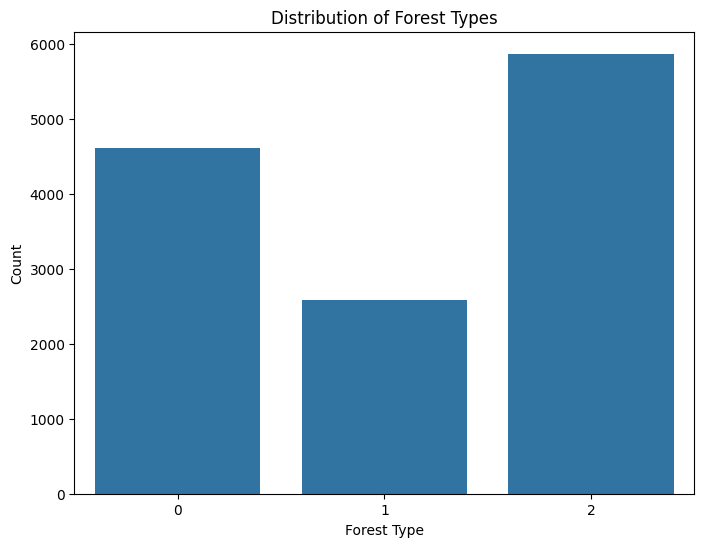

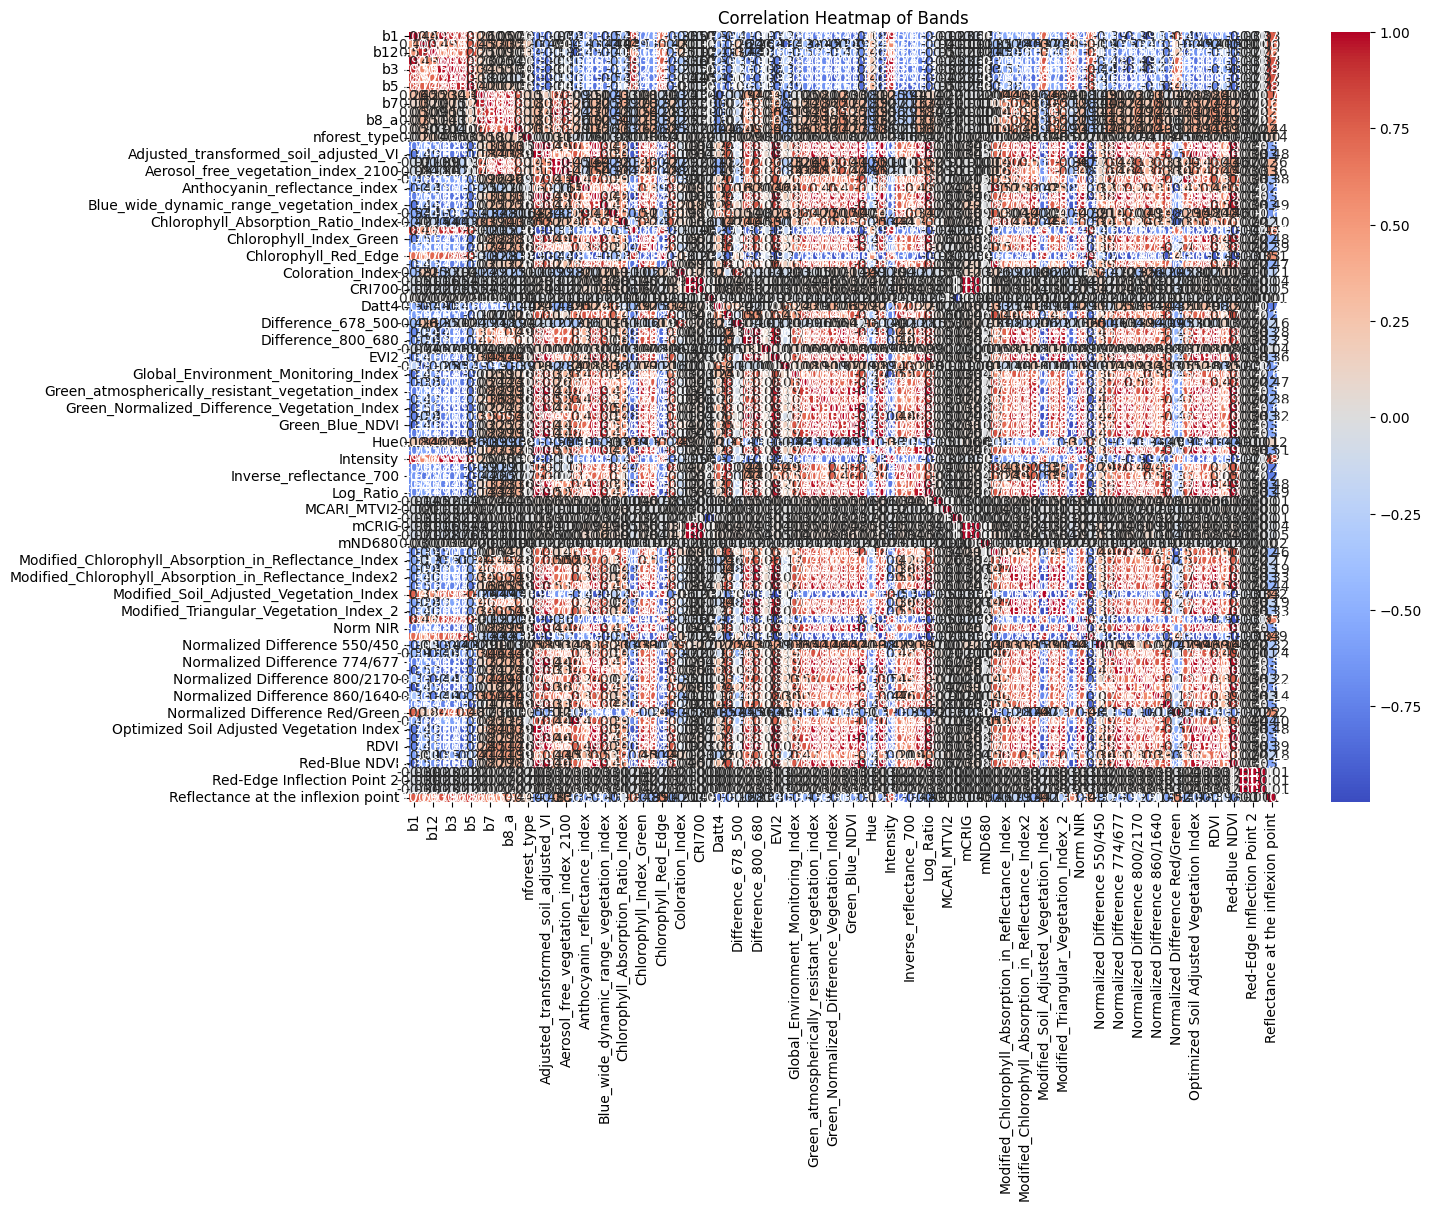

(                 id            b1           b11           b12            b2  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean    8546.088179      0.134858      0.434483      0.179124      0.161371   
 std     4918.719492      0.115918      0.081769      0.053731      0.125425   
 min        0.000000      0.000000      0.040633      0.013016      0.000403   
 25%     4280.000000      0.069190      0.372263      0.139567      0.088710   
 50%     8540.000000      0.093272      0.431630      0.170805      0.114919   
 75%    12798.000000      0.153670      0.489538      0.209451      0.182661   
 max    17051.000000      1.000000      1.000000      1.000000      1.000000   
 
                  b3            b4            b5            b6            b7  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean       0.216965      0.176727      0.288734      0.516985      0.508525   
 std        0.108889      0.117288    

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary_stats = train_df_new_num.describe()

# Distribution of forest types
forest_type_distribution = train_df_new_num['nforest_type'].value_counts()

# Correlation analysis
correlation_matrix = train_df_new_num.drop(columns=['id']).corr()

# Plotting the distribution of forest types
plt.figure(figsize=(8, 6))
sns.barplot(x=forest_type_distribution.index, y=forest_type_distribution.values)
plt.title('Distribution of Forest Types')
plt.xlabel('Forest Type')
plt.ylabel('Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Bands')
plt.show()

summary_stats, forest_type_distribution

******************
------------------------------------
## Feature selection (RFECV)

In [42]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


normalized_train_data = train_df_new_num.copy()

# Check for any infinity or NaN values
print("Checking for infinity values:")
print(np.isinf(normalized_train_data).sum())
print("Checking for NaN values:")
print(normalized_train_data.isna().sum())

# Replace infinity values with NaN and drop them
normalized_train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
normalized_train_data.dropna(inplace=True)

# Prepare the data for RFECV
X_for_select = normalized_train_data.drop(['id', 'nforest_type'], axis=1)
y_for_select = normalized_train_data['nforest_type']

# Define the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the RFECV
rfecv = RFECV(estimator=classifier, step=1, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the RFECV to the data
rfecv.fit(X_for_select, y_for_select)

# Get the selected features
selected_features_rfecv = X_for_select.columns[rfecv.support_].tolist()

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.show()

# Print the selected features
print(selected_features_rfecv)


Checking for infinity values:
id                                    0
b1                                    0
b11                                   0
b12                                   0
b2                                    0
                                     ..
Red-Blue NDVI                         0
Red-Edge Inflection Point 1           1
Red-Edge Inflection Point 2           1
Red-Edge Inflection Point 3           1
Reflectance at the inflexion point    0
Length: 92, dtype: int64
Checking for NaN values:
id                                    0
b1                                    0
b11                                   0
b12                                   0
b2                                    0
                                     ..
Red-Blue NDVI                         0
Red-Edge Inflection Point 1           0
Red-Edge Inflection Point 2           0
Red-Edge Inflection Point 3           0
Reflectance at the inflexion point    0
Length: 92, dtype: int64


KeyboardInterrupt: 

---------------------------

## Feature Selection (Union Correlation Matrix + Mutual Information + RF Feature Importance)

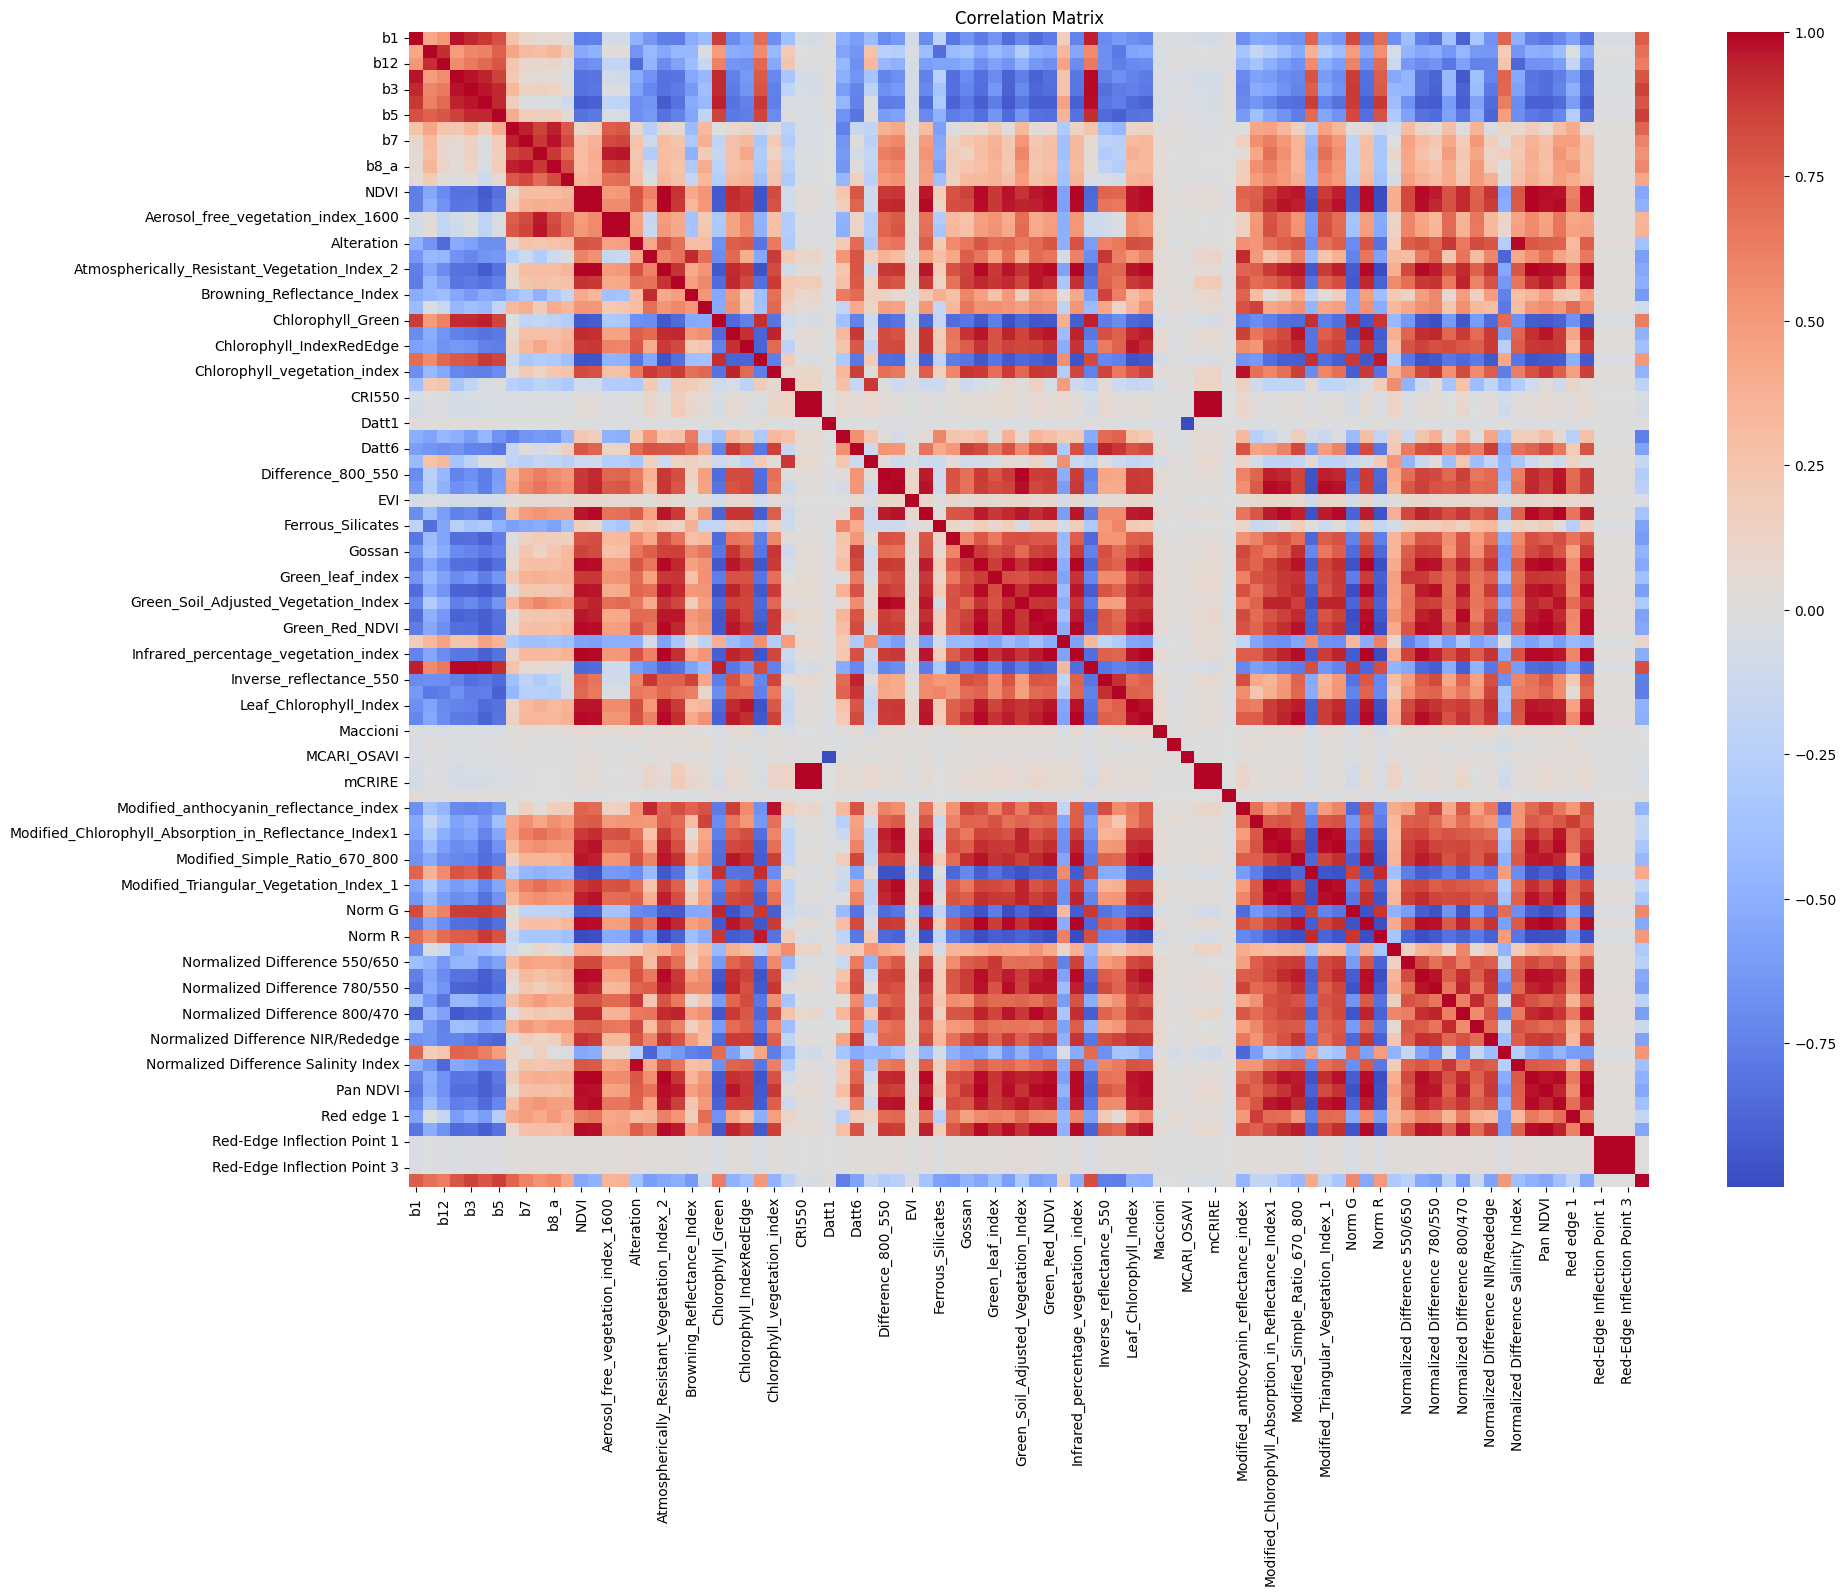

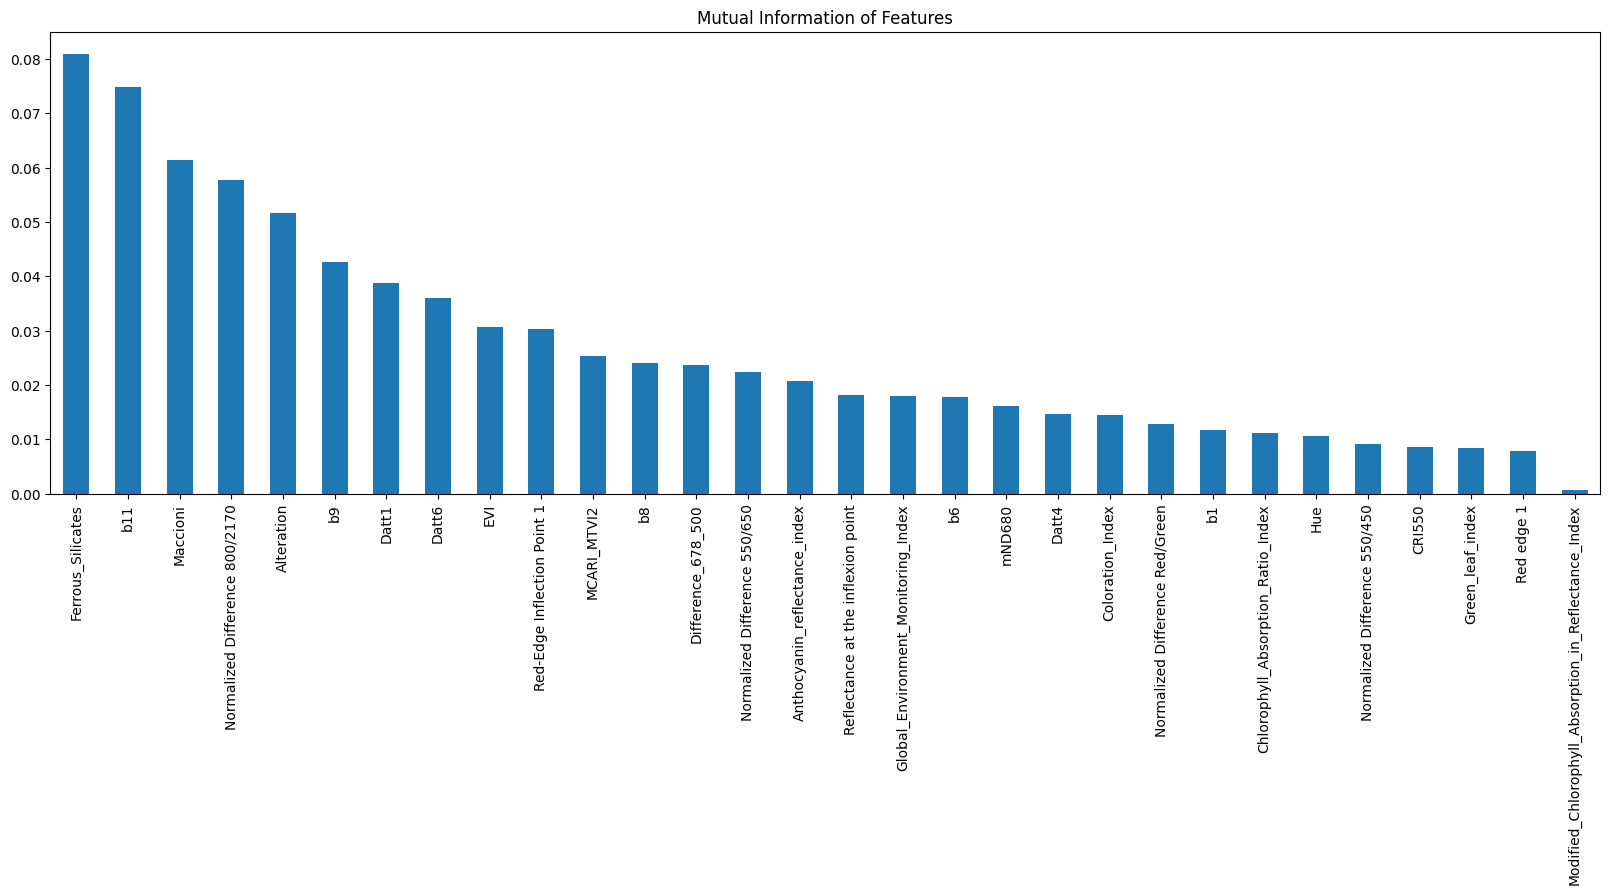

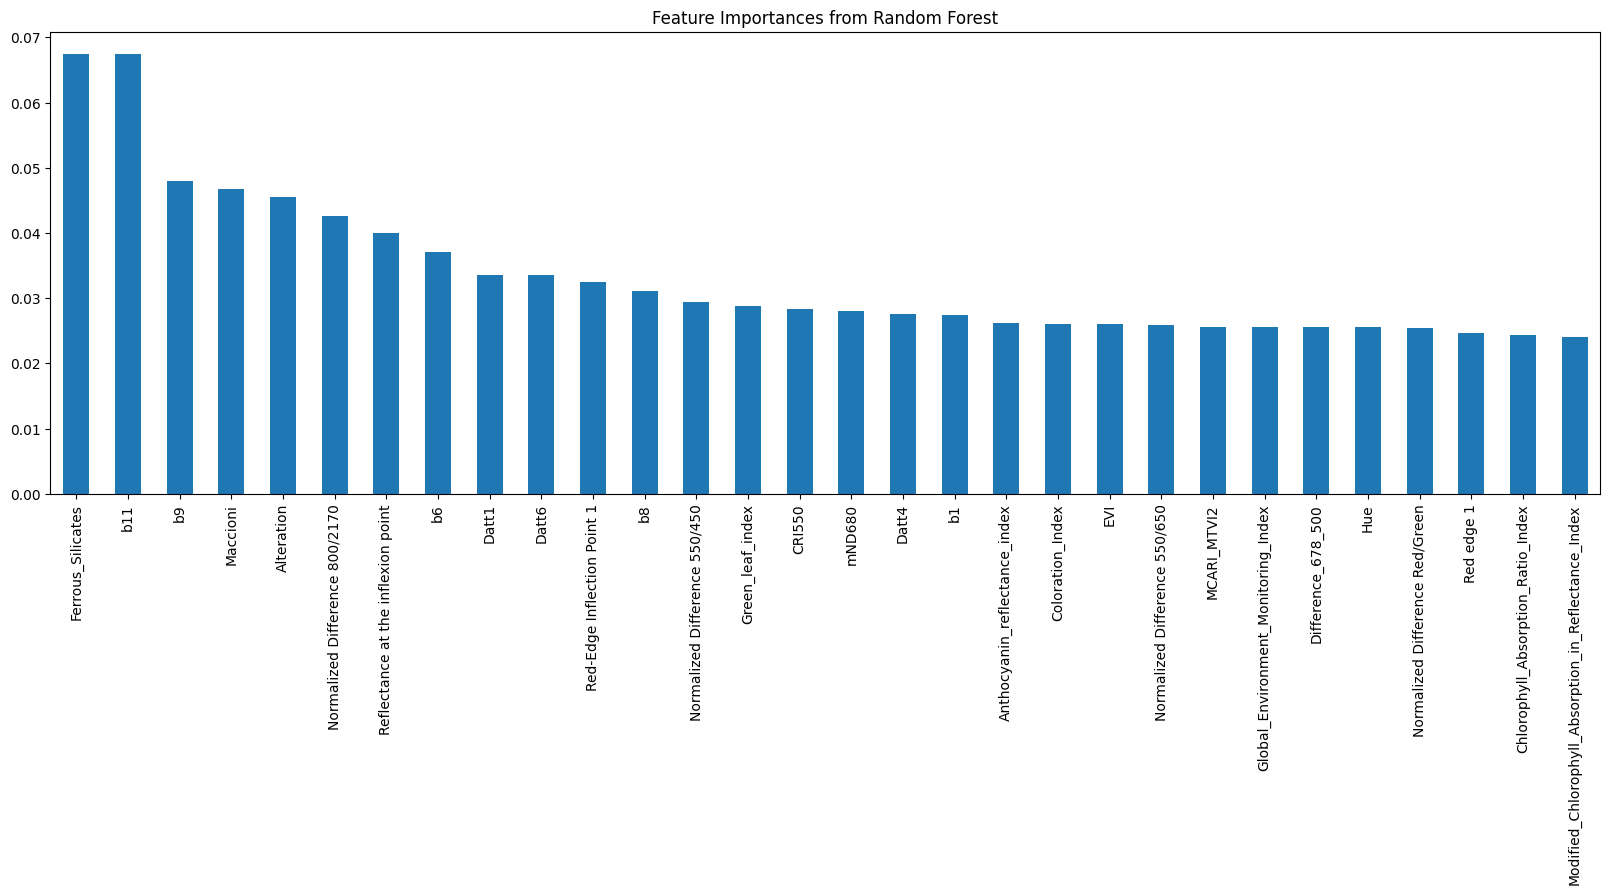

['Green_leaf_index',
 'Datt1',
 'MCARI_MTVI2',
 'Anthocyanin_reflectance_index',
 'Reflectance at the inflexion point',
 'mND680',
 'b9',
 'Ferrous_Silicates',
 'b8',
 'Datt6',
 'Datt4',
 'Maccioni',
 'Difference_678_500',
 'Normalized Difference 550/450',
 'b1',
 'Coloration_Index',
 'b6',
 'Normalized Difference 550/650',
 'CRI550',
 'Alteration',
 'Global_Environment_Monitoring_Index',
 'Red-Edge Inflection Point 1',
 'b11',
 'Normalized Difference 800/2170',
 'EVI']

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Remove the target column for correlation analysis
X_for_select = train_df_new_num.drop(['id', 'nforest_type'], axis=1)
y_for_select = train_df_new_num['nforest_type']

# Handle infinite values
X_for_select.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, cap very large values
# X_for_select = X_for_select.applymap(lambda x: min(x, 1e10) if x > 1e10 else x)

# Drop rows with NaN values
X_for_select.dropna(inplace=True)
y_for_select = y_for_select.loc[X_for_select.index]

# Step 1: Correlation Matrix
corr_matrix = X_for_select.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Identify and remove highly correlated features (threshold > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
X_for_select_reduced = X_for_select.drop(columns=to_drop)

# Step 2: Mutual Information
mi = mutual_info_classif(X_for_select_reduced, y_for_select, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X_for_select_reduced.columns).sort_values(ascending=False)
plt.figure(figsize=(20, 6))
mi_series.plot.bar()
plt.title("Mutual Information of Features")
plt.show()

# Step 3: Feature Importance using Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_for_select_reduced, y_for_select)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X_for_select_reduced.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 6))
feat_importances.plot.bar()
plt.title("Feature Importances from Random Forest")
plt.show()

# Select top N features based on mutual information and feature importance
top_features_mi = mi_series.head(20).index.tolist()
top_features_rf = feat_importances.head(20).index.tolist()

# Combine the selected features
selected_features = list(set(top_features_mi).union(set(top_features_rf)))
selected_features


In [85]:
# Extend the selected_features list to include 'id' and 'nforest_type'
train_selected_features = selected_features + ['id', 'nforest_type']
test_selected_features = selected_features + ['id']

In [86]:
train_df_new_num = train_df_new_num[train_selected_features]
test_df_new_num = test_df_new_num[test_selected_features]

train_df_new_num

,Green_leaf_index,Datt1,MCARI_MTVI2,Anthocyanin_reflectance_index,Reflectance at the inflexion point,mND680,b9,Ferrous_Silicates,b8,Datt6,...,Normalized Difference 550/650,CRI550,Alteration,Global_Environment_Monitoring_Index,Red-Edge Inflection Point 1,b11,Normalized Difference 800/2170,EVI,id,nforest_type
0,0.097160,0.350893,1.107548,2.470945,0.311508,0.604909,0.364870,-0.261007,0.391914,8.235692,...,-0.008008,3.304021,2.255751,0.591770,-767.137151,0.468856,0.306896,0.322310,2002,2
1,0.203639,0.656062,0.702903,3.135975,0.293402,0.922302,0.322968,-0.249240,0.464934,18.696873,...,0.176405,4.649548,2.785805,0.839757,24.236933,0.388808,0.538239,0.666026,3212,0
2,0.017836,0.663063,0.330182,0.070604,0.415967,1.212296,0.322128,-0.274088,0.493399,3.537141,...,0.055866,-0.090228,2.327636,0.324635,-794.739740,0.480535,0.410020,0.659173,13312,2
3,0.353471,0.772065,0.575736,1.440694,0.329175,0.934441,0.354784,-0.241596,0.623762,19.929920,...,0.372671,6.582477,2.751136,0.994807,144.018402,0.379562,0.637756,0.940991,17020,2
4,0.084493,0.353935,0.878867,1.576755,0.283884,0.433377,0.245288,-0.246521,0.351073,6.930269,...,0.018075,1.891721,2.088528,0.516990,-1312.435275,0.472993,0.215742,0.275047,5967,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,0.090958,0.509738,0.730969,1.544028,0.294684,0.678623,0.252131,-0.260966,0.435025,6.839441,...,0.031383,1.770023,2.236495,0.604475,-1056.268322,0.472019,0.346663,0.400766,9185,0
13049,-0.008709,0.616092,0.925423,0.155362,0.747373,-75.594459,0.726738,-0.331745,0.809406,1.637320,...,-0.027204,0.031782,1.609094,-1.561762,-592.857882,0.876399,0.195525,0.229211,13977,0
13050,0.018793,-0.188842,0.544708,-0.009662,0.393999,0.204309,0.260535,-0.258445,0.400578,2.738505,...,0.023018,0.073219,2.124282,0.095259,-3464.517760,0.488321,0.270760,0.045355,755,0
13051,0.024679,0.756039,0.273000,-0.000780,0.489763,3.164911,0.405811,-0.324244,0.629125,3.793993,...,0.086230,-0.139234,2.360737,0.408030,-161.877218,0.562530,0.450581,1.728581,1616,2


--------

# Step 1: Initial Training and Hyperparameter Tuning with Optuna

In [65]:
!pip uninstall lightgbm
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!pip install lightgbm

Found existing installation: lightgbm 4.1.0
Uninstalling lightgbm-4.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/lightgbm-4.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/lightgbm/*
Proceed (Y/n)? ั
Your response ('ั') was not one of the expected responses: y, n, 
Proceed (Y/n)? y
  Successfully uninstalled lightgbm-4.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.0 MB/s eta 0:00:00


In [66]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.1 MB/s eta 0:00:00


In [67]:
!pip install optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [96]:
# Assign X, y for splittinf train and val
X = train_df_new_num.drop(['id', 'nforest_type'], axis=1)

y = train_df_new_num['nforest_type']

**OptunaSearchCV:** hyperparameter tuning for each classifier (results compiled into df)

In [97]:
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from imblearn.over_sampling import SMOTE

In [98]:
# Set parameters
VAL_SPLIT = 0.15
CV_NUM = 8
SCALE = MinMaxScaler()
seed = 42


# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, stratify=y, random_state=seed)

# Scale the data
X_train_scaled = SCALE.fit_transform(X_train)
X_val_scaled = SCALE.transform(X_val)

# Balance the classes using SMOTE
smote = SMOTE(random_state=seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify the shapes of the resulting datasets

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"y_val shape: {y_val.shape}")


X shape: (13053, 25)
y shape: (13053,)
X_train shape: (11095, 25)
y_train shape: (11095,)
X_train_balanced shape: (14955, 25)
y_train_balanced shape: (14955,)
X_val_scaled shape: (1958, 25)
y_val shape: (1958,)


In [99]:
# Define K-Fold cross-validation
kfold = StratifiedKFold(n_splits=CV_NUM, shuffle=True, random_state=seed)

# Define classifiers and their parameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'solver': optuna.distributions.CategoricalDistribution(['lbfgs', 'saga'])
    }),
    "KNeighborsClassifier": (KNeighborsClassifier(), {
        'n_neighbors': optuna.distributions.IntDistribution(1, 50),
        'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance'])
    }),
    "DecisionTreeClassifier": (DecisionTreeClassifier(random_state=seed), {
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16)
    }),
    "AdaBoostClassifier": (AdaBoostClassifier(DecisionTreeClassifier(random_state=seed), random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True)
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
    }),
    "GradientBoostingClassifier": (GradientBoostingClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32)
    }),
    "SVC": (SVC(), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid'])
    }),
    "MLPClassifier": (MLPClassifier(random_state=seed), {
        'hidden_layer_sizes': optuna.distributions.CategoricalDistribution([(50,), (100,), (50, 50),
                                                                            (100, 100), (50,50,50), (50,100,50)]), #add (50,50,50), (50,100,50)
        'activation': optuna.distributions.CategoricalDistribution(['relu', 'tanh', 'logistic','identity']),
        'alpha': optuna.distributions.FloatDistribution(1e-4, 1e-2, log=True),
        'learning_rate_init': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_iter': optuna.distributions.IntDistribution(200, 1000)
    }),
    "XGBClassifier": (XGBClassifier(random_state=seed, tree_method='gpu_hist'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_child_weight': optuna.distributions.IntDistribution(1, 10)
    }),
    "LGBMClassifier": (LGBMClassifier(random_state=seed, device='gpu'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'num_leaves': optuna.distributions.IntDistribution(2, 256),
        'boosting_type': optuna.distributions.CategoricalDistribution(['gbdt', 'dart'])
    }),
    "CatBoostClassifier": (CatBoostClassifier(random_state=seed, verbose=0, task_type='GPU'), {
        'iterations': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'depth': optuna.distributions.IntDistribution(1, 32) #from 16
    })
}

# Perform hyperparameter tuning using Optuna
optuna_results = []

for name, (classifier, param_grid) in classifiers.items():
    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    optuna_search.fit(X_train_balanced, y_train_balanced)
    best_estimator = optuna_search.best_estimator_
    best_params = optuna_search.best_params_
    best_score = optuna_search.best_score_
    print(f'[model: {name}]')
    print("Best Parameters: ", best_params)
    print("Best Estimator: ", best_estimator)
    print("Best Score: ", best_score)
    print('---------------------')
    optuna_results.append((name, best_score, best_params, best_estimator))

# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

optuna_results_df.to_csv(f'{results_path}/optuna_results_df_feat04_union.csv', index=False)

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but cont

[model: LogisticRegression]
Best Parameters:  {'C': 26.850519942769324, 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=26.850519942769324, max_iter=1000)
Best Score:  0.6345694815209025
---------------------


[I 2024-06-06 09:47:29,722] Trial 0 finished with value: 0.7135410497191726 and parameters: {'n_neighbors': 40, 'weights': 'distance'}. Best is trial 0 with value: 0.7135410497191726.
[I 2024-06-06 09:47:31,573] Trial 1 finished with value: 0.7390843926947694 and parameters: {'n_neighbors': 11, 'weights': 'distance'}. Best is trial 1 with value: 0.7390843926947694.
[I 2024-06-06 09:47:31,799] Trial 5 finished with value: 0.7193584532893853 and parameters: {'n_neighbors': 30, 'weights': 'distance'}. Best is trial 1 with value: 0.7390843926947694.
[I 2024-06-06 09:47:31,967] Trial 7 finished with value: 0.7170850822453598 and parameters: {'n_neighbors': 33, 'weights': 'distance'}. Best is trial 1 with value: 0.7390843926947694.
[I 2024-06-06 09:47:38,787] Trial 6 finished with value: 0.7234372094087891 and parameters: {'n_neighbors': 3, 'weights': 'uniform'}. Best is trial 1 with value: 0.7390843926947694.
[I 2024-06-06 09:47:39,185] Trial 3 finished with value: 0.6599799214885137 and pa

[model: KNeighborsClassifier]
Best Parameters:  {'n_neighbors': 11, 'weights': 'distance'}
Best Estimator:  KNeighborsClassifier(n_neighbors=11, weights='distance')
Best Score:  0.7390843926947694
---------------------


[I 2024-06-06 09:47:40,924] Trial 7 finished with value: 0.5338661256126557 and parameters: {'max_depth': 2, 'min_samples_split': 8}. Best is trial 7 with value: 0.5338661256126557.
[I 2024-06-06 09:47:40,930] Trial 0 finished with value: 0.5338661256126557 and parameters: {'max_depth': 2, 'min_samples_split': 14}. Best is trial 7 with value: 0.5338661256126557.
[I 2024-06-06 09:47:42,226] Trial 9 finished with value: 0.5547293227812065 and parameters: {'max_depth': 3, 'min_samples_split': 13}. Best is trial 9 with value: 0.5547293227812065.
[I 2024-06-06 09:47:42,406] Trial 3 finished with value: 0.6122354099964806 and parameters: {'max_depth': 6, 'min_samples_split': 14}. Best is trial 3 with value: 0.6122354099964806.
[I 2024-06-06 09:47:43,543] Trial 4 finished with value: 0.6605140370755043 and parameters: {'max_depth': 11, 'min_samples_split': 16}. Best is trial 4 with value: 0.6605140370755043.
[I 2024-06-06 09:47:44,254] Trial 1 finished with value: 0.6572375988188942 and param

[model: DecisionTreeClassifier]
Best Parameters:  {'max_depth': 11, 'min_samples_split': 16}
Best Estimator:  DecisionTreeClassifier(max_depth=11, min_samples_split=16, random_state=42)
Best Score:  0.6605140370755043
---------------------


[I 2024-06-06 09:47:51,463] Trial 4 finished with value: 0.6636577869145615 and parameters: {'n_estimators': 199, 'learning_rate': 0.010243921666661823}. Best is trial 4 with value: 0.6636577869145615.
[I 2024-06-06 09:47:51,499] Trial 7 finished with value: 0.6636577869145615 and parameters: {'n_estimators': 550, 'learning_rate': 0.0806168730922185}. Best is trial 4 with value: 0.6636577869145615.
[I 2024-06-06 09:47:51,639] Trial 3 finished with value: 0.6636577869145615 and parameters: {'n_estimators': 679, 'learning_rate': 0.0034597607072707564}. Best is trial 4 with value: 0.6636577869145615.
[I 2024-06-06 09:47:51,650] Trial 6 finished with value: 0.6636577869145615 and parameters: {'n_estimators': 323, 'learning_rate': 0.023310929930272298}. Best is trial 4 with value: 0.6636577869145615.
[I 2024-06-06 09:47:51,665] Trial 2 finished with value: 0.6636577869145615 and parameters: {'n_estimators': 887, 'learning_rate': 0.04401830397498146}. Best is trial 4 with value: 0.6636577869

[model: AdaBoostClassifier]
Best Parameters:  {'n_estimators': 199, 'learning_rate': 0.010243921666661823}
Best Estimator:  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                   learning_rate=0.010243921666661823, n_estimators=199,
                   random_state=42)
Best Score:  0.6636577869145615
---------------------


[I 2024-06-06 09:48:42,396] Trial 4 finished with value: 0.7582733910724657 and parameters: {'n_estimators': 66, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7582733910724657.
[I 2024-06-06 09:51:17,458] Trial 7 finished with value: 0.7622193157140282 and parameters: {'n_estimators': 289, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.7622193157140282.
[I 2024-06-06 09:51:29,366] Trial 1 finished with value: 0.7551314652520865 and parameters: {'n_estimators': 309, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.7622193157140282.
[I 2024-06-06 09:52:44,270] Trial 5 finished with value: 0.7521225854999813 and parameters: {'n_estimators': 438, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.7622193157140282.
[I 2024-06-06 09:54:31,115] Trial 2 finished with value: 0.7406878124079048 and parameters:

[model: RandomForestClassifier]
Best Parameters:  {'n_estimators': 855, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Estimator:  RandomForestClassifier(max_depth=25, n_estimators=855, random_state=42)
Best Score:  0.7860245834799702
---------------------


[I 2024-06-06 11:36:29,293] Trial 1 finished with value: 0.7430953024723679 and parameters: {'n_estimators': 105, 'learning_rate': 0.011593159755697812, 'max_depth': 14}. Best is trial 1 with value: 0.7430953024723679.
[I 2024-06-06 11:50:21,464] Trial 3 finished with value: 0.7143424734551634 and parameters: {'n_estimators': 94, 'learning_rate': 0.005575505329944924, 'max_depth': 16}. Best is trial 1 with value: 0.7430953024723679.
[I 2024-06-06 13:03:51,940] Trial 4 finished with value: 0.776395767704426 and parameters: {'n_estimators': 259, 'learning_rate': 0.012634013069717825, 'max_depth': 13}. Best is trial 4 with value: 0.776395767704426.
[I 2024-06-06 13:09:24,579] Trial 0 finished with value: 0.7215644071724707 and parameters: {'n_estimators': 999, 'learning_rate': 0.07458186444795356, 'max_depth': 23}. Best is trial 4 with value: 0.776395767704426.
[I 2024-06-06 14:22:46,984] Trial 9 finished with value: 0.7915742854853892 and parameters: {'n_estimators': 538, 'learning_rate'

[model: GradientBoostingClassifier]
Best Parameters:  {'n_estimators': 538, 'learning_rate': 0.09144972080902913, 'max_depth': 16}
Best Estimator:  GradientBoostingClassifier(learning_rate=0.09144972080902913, max_depth=16,
                           n_estimators=538, random_state=42)
Best Score:  0.7915742854853892
---------------------


[I 2024-06-06 17:38:45,651] Trial 0 finished with value: 0.6346369344469146 and parameters: {'C': 3.8635379798666563, 'kernel': 'linear'}. Best is trial 0 with value: 0.6346369344469146.
[I 2024-06-06 17:38:50,778] Trial 1 finished with value: 0.6656643505205964 and parameters: {'C': 0.3890386062148616, 'kernel': 'poly'}. Best is trial 1 with value: 0.6656643505205964.
[I 2024-06-06 17:39:10,216] Trial 3 finished with value: 0.6704118061933659 and parameters: {'C': 2.4191248513127914, 'kernel': 'rbf'}. Best is trial 3 with value: 0.6704118061933659.
[I 2024-06-06 17:39:10,542] Trial 6 finished with value: 0.6090938775918948 and parameters: {'C': 0.010853603309522522, 'kernel': 'poly'}. Best is trial 3 with value: 0.6704118061933659.
[I 2024-06-06 17:39:22,527] Trial 2 finished with value: 0.5412233585977804 and parameters: {'C': 0.020714507307340098, 'kernel': 'linear'}. Best is trial 3 with value: 0.6704118061933659.
[I 2024-06-06 17:39:28,788] Trial 5 finished with value: 0.428957440

[model: SVC]
Best Parameters:  {'C': 2.4191248513127914, 'kernel': 'rbf'}
Best Estimator:  SVC(C=2.4191248513127914)
Best Score:  0.6704118061933659
---------------------


[I 2024-06-06 17:45:03,700] Trial 5 finished with value: 0.3333333333333333 and parameters: {'hidden_layer_sizes': (50, 100, 50), 'activation': 'tanh', 'alpha': 0.0034296861975776447, 'learning_rate_init': 0.08554180905162675, 'max_iter': 320}. Best is trial 5 with value: 0.3333333333333333.
[I 2024-06-06 17:45:39,205] Trial 4 finished with value: 0.6427214859386043 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.0006129389485847814, 'learning_rate_init': 0.060482045702837973, 'max_iter': 684}. Best is trial 4 with value: 0.6427214859386043.
[I 2024-06-06 17:47:18,465] Trial 7 finished with value: 0.6075551211291463 and parameters: {'hidden_layer_sizes': (50, 50, 50), 'activation': 'identity', 'alpha': 0.00018258342305962005, 'learning_rate_init': 0.012138025026050148, 'max_iter': 216}. Best is trial 4 with value: 0.6427214859386043.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochasti

[model: MLPClassifier]
Best Parameters:  {'hidden_layer_sizes': (100, 100), 'activation': 'tanh', 'alpha': 0.00010144736048020429, 'learning_rate_init': 0.001479393863211848, 'max_iter': 745}
Best Estimator:  MLPClassifier(activation='tanh', alpha=0.00010144736048020429,
              hidden_layer_sizes=(100, 100),
              learning_rate_init=0.001479393863211848, max_iter=745,
              random_state=42)
Best Score:  0.7303905831995721
---------------------


[I 2024-06-06 17:58:43,269] Trial 5 finished with value: 0.6544293968864359 and parameters: {'n_estimators': 337, 'learning_rate': 0.010467906755950558, 'max_depth': 3, 'min_child_weight': 10}. Best is trial 5 with value: 0.6544293968864359.
[I 2024-06-06 18:01:06,449] Trial 0 finished with value: 0.7518545978146111 and parameters: {'n_estimators': 782, 'learning_rate': 0.03263426927824149, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 0 with value: 0.7518545978146111.
[I 2024-06-06 18:01:07,123] Trial 3 finished with value: 0.7616845563557395 and parameters: {'n_estimators': 253, 'learning_rate': 0.029949380149804816, 'max_depth': 10, 'min_child_weight': 10}. Best is trial 3 with value: 0.7616845563557395.
[I 2024-06-06 18:01:15,967] Trial 1 finished with value: 0.7103301330746803 and parameters: {'n_estimators': 139, 'learning_rate': 0.0032297231339259826, 'max_depth': 10, 'min_child_weight': 5}. Best is trial 3 with value: 0.7616845563557395.
[I 2024-06-06 18:01:39,976] Tria

[model: XGBClassifier]
Best Parameters:  {'n_estimators': 983, 'learning_rate': 0.07611485786238478, 'max_depth': 28, 'min_child_weight': 4}
Best Estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07611485786238478,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=28, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=983, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best Score:  0.7911055842153
---------------------


[I 2024-06-06 18:14:58,348] Trial 1 finished with value: 0.7283853429012054 and parameters: {'n_estimators': 55, 'learning_rate': 0.034292239778193435, 'num_leaves': 76, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.7283853429012054.
[I 2024-06-06 18:18:21,417] Trial 2 finished with value: 0.675292415229626 and parameters: {'n_estimators': 412, 'learning_rate': 0.0018069343495712108, 'num_leaves': 27, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.7283853429012054.
[I 2024-06-06 18:19:57,978] Trial 3 finished with value: 0.7749909156716823 and parameters: {'n_estimators': 429, 'learning_rate': 0.05850718708797628, 'num_leaves': 36, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.7749909156716823.
[I 2024-06-06 18:27:06,688] Trial 7 finished with value: 0.7364747584427029 and parameters: {'n_estimators': 908, 'learning_rate': 0.005829026519133763, 'num_leaves': 35, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.7749909156716823.
[I 2024-06-06 18:32:48

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 25
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (0.40 MB) transferred to GPU in 0.001310 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


<ipython-input-99-33b8f7e57630>:68: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-06 19:03:28,599] A new study created in memory with name: no-name-a5a9f92a-3804-4ef3-a227-2bd1bf01711f


[model: LGBMClassifier]
Best Parameters:  {'n_estimators': 877, 'learning_rate': 0.030266411893756708, 'num_leaves': 152, 'boosting_type': 'gbdt'}
Best Estimator:  LGBMClassifier(device='gpu', learning_rate=0.030266411893756708,
               n_estimators=877, num_leaves=152, random_state=42)
Best Score:  0.7941150362085589
---------------------


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-06 19:03:32,902] Trial 0 failed with parameters: {'iterations': 708, 'learning_rate': 0.0017788860591628822, 'depth': 32} because of the following error: The value nan is not acceptable.
[W 2024-06-06 19:03:33,065] Trial 0 failed with value nan.
[W 2024-06-06 19:03:33,162] Trial 2 failed with parameters: {'iterations': 676, 'learning_rate': 0.0779699489975628, 'depth': 2} because of the following error: The value nan is not acceptable.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/l

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 413, 'learning_rate': 0.004504930931192825, 'depth': 10}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7d415cf7c940>
Best Score:  0.6768296337942735
---------------------
                         Model  Best Score  \
0           LogisticRegression    0.634569   
1         KNeighborsClassifier    0.739084   
2       DecisionTreeClassifier    0.660514   
3           AdaBoostClassifier    0.663658   
4       RandomForestClassifier    0.786025   
5   GradientBoostingClassifier    0.791574   
6                          SVC    0.670412   
7                MLPClassifier    0.730391   
8                XGBClassifier    0.791106   
9               LGBMClassifier    0.794115   
10          CatBoostClassifier    0.676830   

                                      Best Parameters  \
0        {'C': 26.850519942769324, 'solver': 'lbfgs'}   
1          {'n_neighbors': 11, 'weights': 'distance'}   
2          {'max_depth': 11

In [100]:
optuna_results

[('LogisticRegression',
  0.6345694815209025,
  {'C': 26.850519942769324, 'solver': 'lbfgs'},
  LogisticRegression(C=26.850519942769324, max_iter=1000)),
 ('KNeighborsClassifier',
  0.7390843926947694,
  {'n_neighbors': 11, 'weights': 'distance'},
  KNeighborsClassifier(n_neighbors=11, weights='distance')),
 ('DecisionTreeClassifier',
  0.6605140370755043,
  {'max_depth': 11, 'min_samples_split': 16},
  DecisionTreeClassifier(max_depth=11, min_samples_split=16, random_state=42)),
 ('AdaBoostClassifier',
  0.6636577869145615,
  {'n_estimators': 199, 'learning_rate': 0.010243921666661823},
  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                     learning_rate=0.010243921666661823, n_estimators=199,
                     random_state=42)),
 ('RandomForestClassifier',
  0.7860245834799702,
  {'n_estimators': 855,
   'max_depth': 25,
   'min_samples_split': 2,
   'min_samples_leaf': 1},
  RandomForestClassifier(max_depth=25, n_estimators=855, random_state=

In [101]:
# !scp /content/results/multmodels_optuna/features_select-RFECV/optuna_results_df_feat04_union.csv ai4054@lanta.nstda.or.th:/project/lt900213-ai24xm/

Host key verification failed.
lost connection


### *** if error occurred during hyperparams tuning

In [ ]:
###for error debugging
optuna_results_df_err = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
optuna_results_df_err.to_csv(f'{results_path}/optuna_results_df_feat01-not-finished.csv', index=False)

In [ ]:
optuna_results_df_err['Model']

0            LogisticRegression
1          KNeighborsClassifier
2        DecisionTreeClassifier
3            AdaBoostClassifier
4        RandomForestClassifier
5    GradientBoostingClassifier
6                           SVC
7                 MLPClassifier
8                 XGBClassifier
Name: Model, dtype: object

In [ ]:
# Perform hyperparameter tuning using Optuna
optuna_results = []

# Skip models that have already been trained
trained_models = optuna_results_df_err['Model'].tolist()

for name, (classifier, param_grid) in classifiers.items():
    if name in trained_models:
        print(f'Skipping already trained model: {name}')
        continue

    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    try:
        optuna_search.fit(X_train, y_train_balanced)
        best_estimator = optuna_search.best_estimator_
        best_params = optuna_search.best_params_
        best_score = optuna_search.best_score_
        print(f'[model: {name}]')
        print("Best Parameters: ", best_params)
        print("Best Estimator: ", best_estimator)
        print("Best Score: ", best_score)
        print('---------------------')
        optuna_results.append((name, best_score, best_params))
    except Exception as e:
        print(f'Error training model {name}: {e}')

# Compile the results
new_optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters"])

# Combine with previous results
combined_optuna_results_df = pd.concat([optuna_results_df, new_optuna_results_df], ignore_index=True)
print(combined_optuna_results_df)

# Save the combined results
combined_optuna_results_df.to_csv(f'{results_path}/combined_optuna_results_df_feat01.csv', index=False)
print(f"Combined results saved to: {results_path}/combined_optuna_results_df_feat01.csv")

<ipython-input-20-cebc5fe5e400>:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-05 09:07:08,020] A new study created in memory with name: no-name-344aaf52-d57c-447e-8ce0-ebbc2191f1c2


Skipping already trained model: LogisticRegression
Skipping already trained model: KNeighborsClassifier
Skipping already trained model: DecisionTreeClassifier
Skipping already trained model: AdaBoostClassifier
Skipping already trained model: RandomForestClassifier
Skipping already trained model: GradientBoostingClassifier
Skipping already trained model: SVC
Skipping already trained model: MLPClassifier
Skipping already trained model: XGBClassifier


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:08,974] Trial 5 failed with parameters: {'n_estimators': 79, 'learning_rate': 0.19188234555422495, 'num_leaves': 23, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,978] Trial 5 failed with value nan.
[W 2024-06-05 09:07:08,988] Trial 3 failed with parameters: {'n_estimators': 184, 'learning_rate': 0.13362042989298442, 'num_leaves': 93, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,992] Trial 3 failed with value nan.
[W 2024-06-05 09:07:08,994] Trial 2 failed with parameters: {'n_es

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 14976, number of used features: 29
Error training model LGBMClassifier: No OpenCL device found


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,398] Trial 1 failed with parameters: {'iterations': 59, 'learning_rate': 0.404665400351513, 'depth': 9} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:14,406] Trial 1 failed with value nan.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,614]

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 150, 'learning_rate': 0.0151103585762203, 'depth': 13}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7c54703bffa0>
Best Score:  0.6694043803418803
---------------------
                        Model  Best Score  \
0          LogisticRegression    0.647903   
1        KNeighborsClassifier    0.732505   
2      DecisionTreeClassifier    0.653846   
3          AdaBoostClassifier    0.655115   
4      RandomForestClassifier    0.765425   
5  GradientBoostingClassifier    0.781317   
6                         SVC    0.685029   
7               MLPClassifier    0.691306   
8               XGBClassifier    0.778646   
9          CatBoostClassifier    0.669404   

                                     Best Parameters  
0        {'C': 8.490782592210358, 'solver': 'lbfgs'}  
1          {'n_neighbors': 9, 'weights': 'distance'}  
2          {'max_depth': 31, 'min_samples_split': 2}  
3  {'n_estimators': 180, 'learning_ra

In [ ]:
combined_optuna_results_df

,Model,Best Score,Best Parameters
0,LogisticRegression,0.647903,"{'C': 8.490782592210358, 'solver': 'lbfgs'}"
1,KNeighborsClassifier,0.732505,"{'n_neighbors': 9, 'weights': 'distance'}"
2,DecisionTreeClassifier,0.653846,"{'max_depth': 31, 'min_samples_split': 2}"
3,AdaBoostClassifier,0.655115,"{'n_estimators': 180, 'learning_rate': 0.02880..."
4,RandomForestClassifier,0.765425,"{'n_estimators': 130, 'max_depth': 21, 'min_sa..."
5,GradientBoostingClassifier,0.781317,"{'n_estimators': 154, 'learning_rate': 0.11829..."
6,SVC,0.685029,"{'C': 4.61538732142158, 'kernel': 'rbf'}"
7,MLPClassifier,0.691306,"{'hidden_layer_sizes': (100, 100), 'activation..."
8,XGBClassifier,0.778646,"{'n_estimators': 106, 'learning_rate': 0.09181..."
9,CatBoostClassifier,0.669404,"{'iterations': 150, 'learning_rate': 0.0151103..."


In [ ]:
optuna_results_df = combined_optuna_results_df.copy()

---------------------------

------------------------------
# Step 2: Select Top Models
## (Include MLPClassifier in the top models)

In [ ]:
# optuna_results_df = pd.read_csv('results/multmodels_optuna/features01-suggest/optuna_results_df_feat04_union.csv')

In [102]:
# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

# Select top models based on validation accuracy
top_6_models = optuna_results_df.sort_values(by='Best Score', ascending=False).head(6)

                         Model  Best Score  \
0           LogisticRegression    0.634569   
1         KNeighborsClassifier    0.739084   
2       DecisionTreeClassifier    0.660514   
3           AdaBoostClassifier    0.663658   
4       RandomForestClassifier    0.786025   
5   GradientBoostingClassifier    0.791574   
6                          SVC    0.670412   
7                MLPClassifier    0.730391   
8                XGBClassifier    0.791106   
9               LGBMClassifier    0.794115   
10          CatBoostClassifier    0.676830   

                                      Best Parameters  \
0        {'C': 26.850519942769324, 'solver': 'lbfgs'}   
1          {'n_neighbors': 11, 'weights': 'distance'}   
2          {'max_depth': 11, 'min_samples_split': 16}   
3   {'n_estimators': 199, 'learning_rate': 0.01024...   
4   {'n_estimators': 855, 'max_depth': 25, 'min_sa...   
5   {'n_estimators': 538, 'learning_rate': 0.09144...   
6          {'C': 2.4191248513127914, 'kernel': '

In [103]:
top_6_models

,Model,Best Score,Best Parameters,Best Estimator
9,LGBMClassifier,0.794115,"{'n_estimators': 877, 'learning_rate': 0.03026...","LGBMClassifier(device='gpu', learning_rate=0.0..."
5,GradientBoostingClassifier,0.791574,"{'n_estimators': 538, 'learning_rate': 0.09144...",([DecisionTreeRegressor(criterion='friedman_ms...
8,XGBClassifier,0.791106,"{'n_estimators': 983, 'learning_rate': 0.07611...","XGBClassifier(base_score=None, booster=None, c..."
4,RandomForestClassifier,0.786025,"{'n_estimators': 855, 'max_depth': 25, 'min_sa...","(DecisionTreeClassifier(max_depth=25, max_feat..."
1,KNeighborsClassifier,0.739084,"{'n_neighbors': 11, 'weights': 'distance'}","KNeighborsClassifier(n_neighbors=11, weights='..."
7,MLPClassifier,0.730391,"{'hidden_layer_sizes': (100, 100), 'activation...","MLPClassifier(activation='tanh', alpha=0.00010..."


# Step 3: Predictions

## Retrain each top model(full training data)

In [104]:
X_combined = np.concatenate([X_train_balanced, X_val])
y_combined = np.concatenate([y_train_balanced, y_val])
print(X_combined.shape, y_combined.shape)

(16913, 25) (16913,)


In [ ]:
retrained_models = []
for index, row in top_6_models.iterrows():
    model_name = row['Model']
    best_estimator = row['Best Estimator']
    best_params = row['Best Parameters']

    # Ensure best_params is a dictionary
    if isinstance(best_params, str):
        best_params = eval(best_params)  # Convert string representation of dictionary to actual dictionary
    if isinstance(best_estimator, str):
        best_estimator = globals()[model_name](**best_params)

    # best_estimator.fit(X_train, y_train_balanced)
    best_estimator.fit(X_combined, y_combined)
    retrained_models.append((model_name, best_estimator))

# Evaluate fine-tuned models on the validation set
retrained_models_acc = []
for model_name, model in retrained_models:
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    retrained_models_acc.append((model_name, accuracy))
    print(f'Validation Accuracy for {model_name}: {accuracy}')

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 16913, number of used features: 25
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (0.45 MB) transferred to GPU in 0.001291 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.092012
[LightGBM] [Info] Start training from score -1.146696
[LightGBM] [Info] Start training from score -1.059080


In [ ]:
# sorted_retrained_models_acc = sorted(retrained_models_acc, key=lambda x: x[1], reverse=True)
# sorted_retrained_models_acc

[('LGBMClassifier', 0.7007150153217568),
 ('XGBClassifier', 0.6751787538304392),
 ('RandomForestClassifier', 0.6731358529111338),
 ('MLPClassifier', 0.6639427987742594),
 ('GradientBoostingClassifier', 0.658835546475996),
 ('KNeighborsClassifier', 0.6021450459652706)]

In [ ]:
# retrained_models_dict = dict(retrained_models)
# sorted_retrained_models = [(model_name, retrained_models_dict[model_name]) for model_name, _ in sorted_retrained_models_acc]
# print(sorted_retrained_models)
sorted_retrained_models = retrained_models

## Voting Classifier

In [ ]:
# import numpy as np
# def predict_with_models(models, test_features):
#     predictions = []
#     for model_name, model in models:
#         predictions.append(model.predict(test_features))
#     return np.array(predictions).T
# top_3_models = sorted_retrained_models[:3]

# checkpred = predict_with_models(top_3_models, test_features)
# checkpred

array([[1, 1, 1],
       [0, 0, 0],
       [2, 2, 2],
       ...,
       [0, 1, 1],
       [2, 2, 2],
       [1, 1, 1]])

In [ ]:
# # Weighted voting function
# def weighted_voting(predictions, weights):
#     final_predictions_encoded = []
#     for instance_predictions in predictions:
#         weighted_votes = np.zeros(len(weights))  # Assuming there are 3 classes
#         for i, vote in enumerate(instance_predictions):
#             weighted_votes[vote] += weights[i]
#         final_predictions_encoded.append(np.argmax(weighted_votes))
#     return final_predictions_encoded

# a = [[0, 1, 2, 1, 0]]
# w = [0.6, 0.5, 0.3, 0.4, 0.55]
# weighted_voting(a, w)

[0]

In [ ]:
# Custom Voting Classifier Implementation
test_ids = test_df_new['id']
test_features = test_df_new.drop(columns=['id'])

test_features.columns = test_features.columns.astype(str)

test_features = SCALE.transform(test_features)

In [ ]:
# Calculate weights for the top 3 models
weights_top_3 = sorted_retrained_models['Best Score'].head(3).tolist()

# Calculate weights for the top 5 models
weights_top_5 = sorted_retrained_models['Best Score'].head(5).tolist()

# Output the weights
print("Weights for Top 3 models:", weights_top_3)
print("Weights for Top 5 models:", weights_top_5)

In [ ]:
# Predict with each of the top models
def predict_with_models(models, test_features):
    predictions = []
    for model_name, model in models:
        predictions.append(model.predict(test_features))
    return np.array(predictions).T

# Weighted voting function
def weighted_voting(predictions, weights):
    final_predictions_encoded = []
    for instance_predictions in predictions:
        weighted_votes = np.zeros(len(weights))  # Assuming there are 3 classes
        for i, vote in enumerate(instance_predictions):
            weighted_votes[vote] += weights[i]
        final_predictions_encoded.append(np.argmax(weighted_votes))
    return final_predictions_encoded

# Perform predictions and voting for top 3, top 5, and the best model
top_3_models = retrained_models[:3]
top_5_models = retrained_models[:5]
best_model = retrained_models[0]

# # Calculate weights for models
# weights_top_3 = [0.7007150153217568, 0.6751787538304392, 0.6705822267620021]
# weights_top_5 = [0.7007150153217568, 0.6751787538304392, 0.6705822267620021, 0.6629213483146067, 0.660367722165475]

# Predict and vote
predictions_top_3 = predict_with_models(top_3_models, test_features)
predictions_top_5 = predict_with_models(top_5_models, test_features)
predictions_best = best_model[1].predict(test_features)  # Best model directly

# Weighted voting
final_predictions_top_3 = weighted_voting(predictions_top_3, weights_top_3)
final_predictions_top_5 = weighted_voting(predictions_top_5, weights_top_5)

# Map the encoded predictions back to the original labels
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
final_predictions_top_3 = [inverse_label_mapping[pred] for pred in final_predictions_top_3]
final_predictions_top_5 = [inverse_label_mapping[pred] for pred in final_predictions_top_5]
final_predictions_best = [inverse_label_mapping[pred] for pred in predictions_best]

# Prepare submission DataFrames
submission_top_3 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_3
})
submission_top_5 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_5
})
submission_best = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_best
})

# Save submission files
submission_top_3_file_path = 'results/multmodels_optuna/features01-suggest/cat_optuna_top_3_submission.csv'
submission_top_5_file_path = 'results/multmodels_optuna/features01-suggest/cat_optuna_top_5_submission.csv'
submission_best_file_path = 'results/multmodels_optuna/features01-suggest/cat_optuna_best_submission.csv'

submission_top_3.to_csv(submission_top_3_file_path, index=False)
submission_top_5.to_csv(submission_top_5_file_path, index=False)
submission_best.to_csv(submission_best_file_path, index=False)

print(f"Submission files saved at:\n{submission_top_3_file_path}\n{submission_top_5_file_path}\n{submission_best_file_path}")

Submission files saved at:
results/multmodels_optuna/features01-suggest/cat_optuna_top_3_submission.csv
results/multmodels_optuna/features01-suggest/cat_optuna_top_5_submission.csv
results/multmodels_optuna/features01-suggest/cat_optuna_best_submission.csv


------------------

------------------

# Check similarity between two results

Training results should have classes Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}
- DDF(0): 1488
- DEF(1): 1000
- MDF(2): 1512
(Total: 4000)

In [ ]:
import pandas as pd

def countclass(df):
  # Assuming you have a pandas DataFrame 'df' with a column 'nforest_type'
  nforest_type_counts = df['nforest_type'].value_counts()

  # Count occurrences of 'DDF'
  ddf_count = nforest_type_counts.get('DDF', 0)

  # Count occurrences of 'DEF'
  def_count = nforest_type_counts.get('DEF', 0)

  # Count occurrences of 'MDF'
  mdf_count = nforest_type_counts.get('MDF', 0)

  print(f"Number of DDF: {ddf_count}, DEF:{def_count}, MDF:{mdf_count}")

In [ ]:
# Load the two submission files
df1 = pd.read_csv('/content/pim_feat01_optuna_best_submission.csv') #0.68616
df2 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_best_submission.csv')
df3 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_3_submission.csv')
df4 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_5_submission.csv')
# Check similarity between the two results
similarity_check2 = (df2['nforest_type'] == df1['nforest_type']).mean()
similarity_check3 = (df3['nforest_type'] == df1['nforest_type']).mean()
similarity_check4 = (df4['nforest_type'] == df1['nforest_type']).mean()

print("Class in testing set:")
print("Number of DDF: 1488, DEF:1000, MDF:1512")
print("-----------------------------------")
print("yesterday's best model(LGBM)")
countclass(df1)

print("\nBest model(LGBM):")
countclass(df2)
print(f"similarity:{similarity_check2}")

print("\nTop3:")
countclass(df3)
print(f"similarity:{similarity_check3}")

print("\nTop5:")
countclass(df4)
print(f"similarity:{similarity_check4}")

------------------
------------------
### Results record
**submission_majority_voting_1.csv**
- score acc 0.65615
- Number of DDF: 1400, DEF:831, MDF:1769

.........................

**submission_majority_voting_2.csv**
```
Raw Data
Split 0.15, cv_num = 8 for girdsearchCV  
เปิดtrain+SMOTE ให้เห็นหมดตอน Majority vote
```
- score acc 0.66480
- Number of DDF: 1402, DEF:848, MDF:1750

.........................

**submission_majority_voting_prepdat01.csv**
```
prepdata select features: ['b2', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'NDVI', 'Moisture_Index', 'natural_color', 'false_color', 'vegetation_analysis', 'swir']
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

```
- score: 0.62767
- Number of DDF: 1384, DEF:827, MDF:1789

.........................

**submission_majority_voting_prepdat02.csv**
```
prepdata 18 features
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.66429
- Number of DDF: 1434, DEF:856, MDF:1710

.........................


**submission_3voting_prepfeats.csv**
```
data with 29 features (jane's features no drop)
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.67293
- Number of DDF: 1420, DEF:835, MDF:1745

.........................

**submission 05062024**
```
- data feature01 (featuresเจน)
- เปลี่ยน gridsearchCV เป็น Optuna
- ตอนแรกเทรนแบบ stratified split + SMOTE
- แล้วพอได้best model เอามา  retrain w/ training data (train+val)
- ทำ voting ใช้ weighted
```
retrain w/ training data (train+val)
- **best(LGBM): 0.68616**
  - Number of DDF: 1501, DEF:915, MDF:1584
- top 3: 0.68514
- top 5: 0.68209

retrain w/ training data (splitted train)
- best(LGBM): 0.67751
- top 3: 0.67395
- top 5: 0.66887

.............................

**submission 06062024**
```
- data feature02 (featuresเจน+มโนธรรม)
- เปลี่ยน gridsearchCV เป็น Optuna
- ตอนแรกเทรนแบบ stratified split + SMOTE
- แล้วพอได้best model เอามา  retrain w/ training data (train+val)
- ทำ voting ใช้ weighted
```
- Best model(LGBM): 0.68260
  - Number of DDF: 1475, DEF:899, MDF:1626

- Top3: -
  - Number of DDF: 1467, DEF:914, MDF:1619

- Top5: 0.68260
  - Number of DDF: 1472, DEF:924, MDF:1604
------------------
------------------